In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM

from utils import display_metrics

import warnings
warnings.filterwarnings('ignore')


2024-03-13 07:20:15.780557: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-13 07:20:15.780600: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-13 07:20:15.782361: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-13 07:20:15.791523: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-13 07:20:16.989894: W tensorflow/compiler/tf2

In [2]:
df = pd.read_csv('energy_antananarivo_cleaned.csv',index_col='date_dep_dmd',parse_dates=True)

In [3]:
df = df.drop('tot_energy', axis=1)

## Répartition Entraînement / Test

In [4]:
# Créer des ensembles de train et de test
train_df, test_df = train_test_split(df, test_size=0.1, shuffle=False)

## Mise à l'échelle des données

In [5]:
scaler = MinMaxScaler()

In [6]:
scaler.fit(train_df)

MinMaxScaler()

In [7]:
scaled_train = scaler.transform(train_df)
scaled_test = scaler.transform(test_df)

In [8]:
## Générateur de séries temporelles
length = 12
n_features=1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

## Création du modèle avec LSTM

In [9]:
# définir le modèle
model = Sequential()
model.add(LSTM(75, input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [10]:
validation_generator = TimeseriesGenerator(scaled_test, scaled_test, length=length, batch_size=1)
early_stop = EarlyStopping(monitor='val_loss',patience=2)
model.fit(generator,epochs=10, validation_data=validation_generator, callbacks=[early_stop])

Epoch 1/10
247/247 [==============================] - 6s 10ms/step - loss: 0.0119 - val_loss: 0.0220
Epoch 2/10
247/247 [==============================] - 2s 6ms/step - loss: 0.0081 - val_loss: 0.0133
Epoch 3/10
247/247 [==============================] - 2s 6ms/step - loss: 0.0073 - val_loss: 0.0090
Epoch 4/10
247/247 [==============================] - 2s 6ms/step - loss: 0.0063 - val_loss: 0.0063
Epoch 5/10
247/247 [==============================] - 2s 6ms/step - loss: 0.0073 - val_loss: 0.0051
Epoch 6/10
247/247 [==============================] - 2s 6ms/step - loss: 0.0050 - val_loss: 0.0042
Epoch 7/10
247/247 [==============================] - 1s 6ms/step - loss: 0.0047 - val_loss: 0.0091
Epoch 8/10
247/247 [==============================] - 2s 6ms/step - loss: 0.0038 - val_loss: 0.0019
Epoch 9/10
247/247 [==============================] - 2s 6ms/step - loss: 0.0033 - val_loss: 0.0023
Epoch 10/10
247/247 [==============================] - 2s 6ms/step - loss: 0.0034 - val_loss: 0.001

<Axes: >

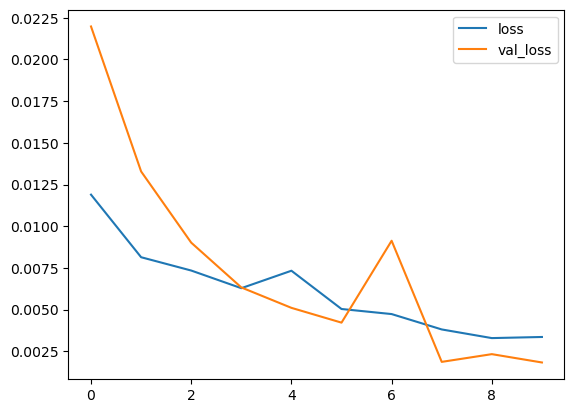

In [11]:
losses = pd.DataFrame(model.history.history)
losses.plot()

## Évaluation sur les données Test

In [12]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test_df)):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 23ms/step


In [13]:
true_predictions = scaler.inverse_transform(test_predictions)
test_df['LSTM Predictions'] = true_predictions
np.sqrt(mean_squared_error(test_df['tot_nb_dmd'],test_df['LSTM Predictions']))

100.19744507097238

<Axes: xlabel='date_dep_dmd'>

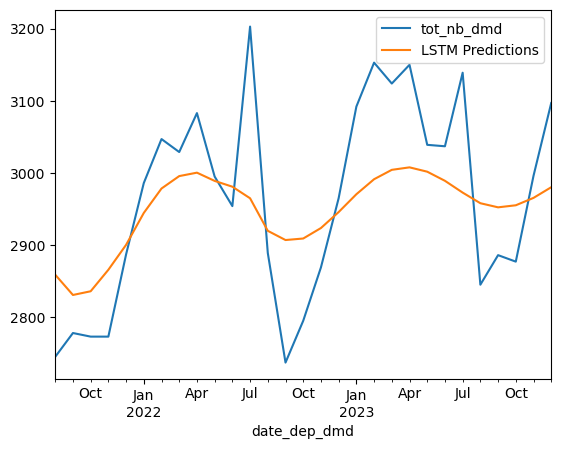

In [14]:
test_df.plot()

## Re-entrainement et Prévisions

In [15]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [16]:
length = 12 # Longueur des séquences de sortie (en nombre de pas temporel)
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [17]:
# Modèle LSTM
model = Sequential()
model.add(LSTM(75, input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

validation_generator = TimeseriesGenerator(scaled_test, scaled_test, length=length, batch_size=1)
early_stop = EarlyStopping(monitor='val_loss',patience=2)
model.fit(generator,epochs=10, validation_data=validation_generator, callbacks=[early_stop])

Epoch 1/10
276/276 [==============================] - 5s 9ms/step - loss: 0.0123 - val_loss: 0.0057
Epoch 2/10
276/276 [==============================] - 2s 6ms/step - loss: 0.0072 - val_loss: 0.0049
Epoch 3/10
276/276 [==============================] - 2s 6ms/step - loss: 0.0057 - val_loss: 0.0111
Epoch 4/10
276/276 [==============================] - 2s 6ms/step - loss: 0.0058 - val_loss: 0.0050


In [18]:
forecast = []
periods = 12
first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    current_pred = model.predict(current_batch)[0]
    forecast.append(current_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 18ms/step


In [19]:
forecast = full_scaler.inverse_transform(forecast)

## Création d'un nouvel index TimeStamp avec Pandas

In [20]:
forecast_index = pd.date_range(start='2023-12-01',periods=periods,freq='MS')
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,
                           columns=['Forecast'])

In [21]:
forecast_df

,Forecast
2023-12-01,2975.248495
2024-01-01,2964.725845
2024-02-01,2952.132580
2024-03-01,2940.478962
2024-04-01,2927.304718
2024-05-01,2918.930686
2024-06-01,2910.734761
2024-07-01,2897.569989
2024-08-01,2897.847848
2024-09-01,2896.966673


<Axes: >

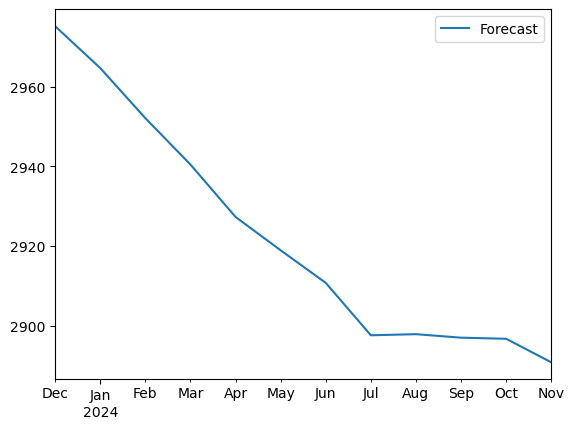

In [22]:
forecast_df.plot()

## Unification des graphiques avec Pandas

<Axes: xlabel='date_dep_dmd'>

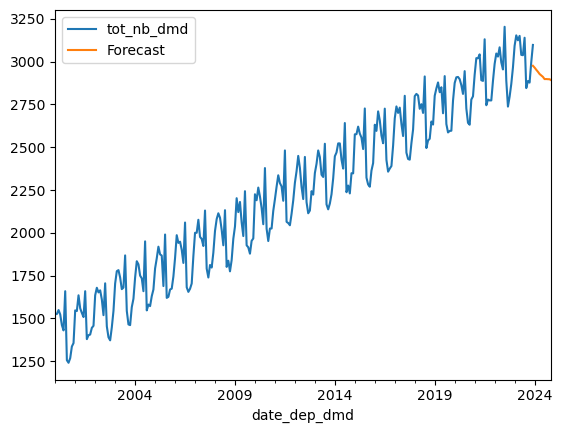

In [23]:
ax = df.plot()
forecast_df.plot(ax=ax)

(600.0, 658.0)

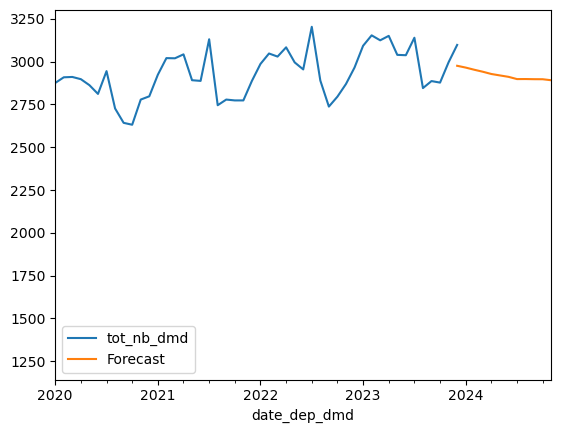

In [24]:
ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim('2020-01-01','2024-11-01')

## Calcul des metriques

In [25]:
np.sqrt(mean_squared_error(test_df['tot_nb_dmd'],test_df['LSTM Predictions']))

100.19744507097238

In [27]:
train_pred = model.predict(train_df)
perf = display_metrics(train_df, train_pred,test_df['tot_nb_dmd'], true_predictions)
perf

9/9 [==============================] - 1s 2ms/step


,Métriques:,Ensemble d'entrainenemt:,Ensemble de test:
0,MAE,2.146672e+03,83.540053
1,MSE,4.814673e+06,10039.527999
2,RMSE,2.194236e+03,100.197445
3,R²,-2.231907e+01,0.461370
